In [1]:
# notebook analysing a single model trained on MNIST
# 1- load model
# 2- evaluate
# 3- plot histories
# 4- histogram over train/val data
# 5- histogram over random noise (two types)

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [3]:
import torch

import numpy as np
from scipy import stats

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [4]:
!gpustat

countdown               Wed Jun 24 11:24:05 2020  418.87.01
[0] GeForce RTX 2080 Ti | 45'C,   0 % |     1 / 10989 MB |
[1] GeForce RTX 2080 Ti | 45'C,   0 % |   171 / 10988 MB | root(169M)


In [5]:
# Define what device we are using

# manualy set cuda device
torch.cuda.set_device(0)
                      
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

CUDA Available:  True
Using device: cuda


In [6]:
# load MNIST data
batch_sizefor_train = 10000
batch_size_for_val = 10000
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size=batch_sizefor_train,
                                                                                   batch_size_for_val=batch_size_for_val)

<IPython.core.display.Javascript object>


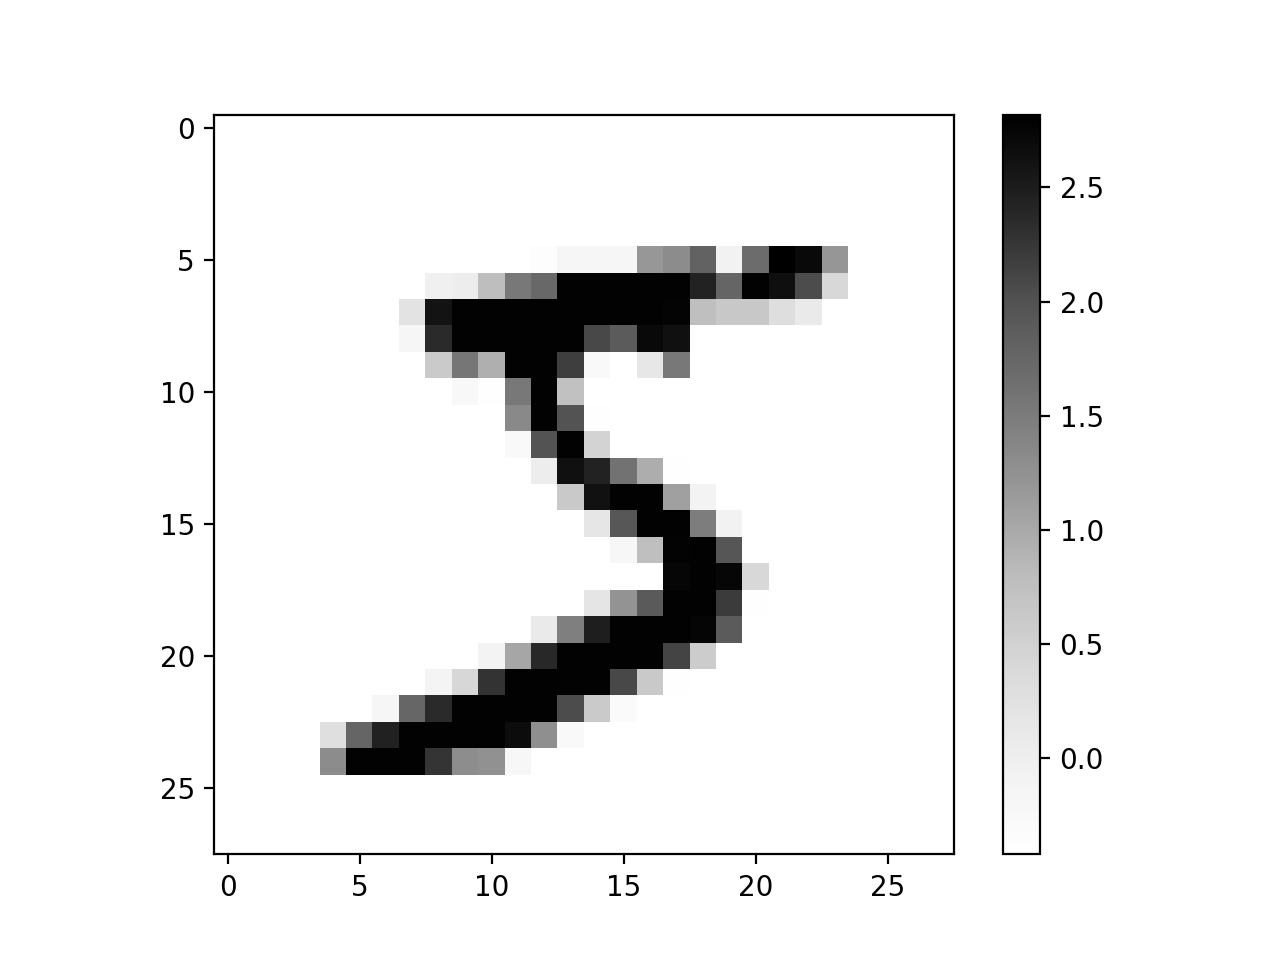

In [7]:
# show an example
x = mnist_train_loader.dataset.tensors[0][0]
plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

In [8]:
# 1 - load the model

In [9]:
# model_path = '../Experiments/Exp-00/2020_01_07_at_23:28:46/classic_hl[1024, 1024, 1024]_dp0.4_ite4/'
# model_path = '../Experiments/Exp-00/2020_01_07_at_23:28:46//FGNs/fgn_hl[256]_dp0.0_diag_ord2.0_ls1.6e-05_ite0/'
# model_path = '../Experiments/Exp-00/2020_01_07_at_16:40:22 (no dropout)/classic_hl[1024, 1024, 1024]_dp0.0_ite4/converted FGNs/converted_fgn_hl[1024, 1024, 1024]_dp0.0_sphere_ord0.5_ls8e-08'

model_path = '../Experiments/Exp-00/2020_01_07_at_23:28:46/classic_hl[256, 256]_dp0.4_ite3/'
fgn_model_path = '/converted FGNs/'
sub_path = '/converted_fgn_hl[256, 256]_dp0.4_diag_ord2.0_ls8e-08/'
model_path = model_path+fgn_model_path+sub_path

In [10]:
# full load
if 'FGNs' in model_path and 'converted' not in model_path:
    model = torch.load(model_path+'/trained_fgn_model_full.pth')
elif 'converted' in model_path:
    model = torch.load(model_path+'/trained_converted_fgn_model_full.pth')
else:
    model = torch.load(model_path+'/trained_classic_model_full.pth')

    
# set to eval
model.eval()

# FGN models, set random eval
try:
    model.set_random_eval(True)
except:
    pass
model.to(device)

/home/apps/anaconda/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'Finite_Gaussian_Network_lib.Feedforward_FGN_net.Feedforward_FGN_net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/apps/anaconda/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/apps/anaconda/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'Finite_Gaussian_Network_lib.FGN_layer.FGN_layer' has changed. you can retrieve

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.4, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.4, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [11]:
print(model)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.4, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.4, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)


In [12]:
# 2 - Evaluate

In [13]:
cent_loss_func = fgnh.def_classical_cross_ent_loss()
pred_func = fgnh.cross_ent_pred_accuracy

print("over training data")
trainset_res = fgnh.test(model, mnist_train_loader, cent_loss_func, pred_func=pred_func, verbose=True)
print("over validation data")
trainset_res = fgnh.test(model, mnist_val_loader, cent_loss_func, pred_func=pred_func, verbose=True)

over training data
Test set - Average loss: 0.0869, Accuracy: 48634/50000 (97%)
over validation data
Test set - Average loss: 0.1024, Accuracy: 9697/10000 (97%)


In [14]:
# 3 - plot histories

In [15]:
train_histories = np.load(model_path+"/train_histories.pckl", allow_pickle=True)

<IPython.core.display.Javascript object>


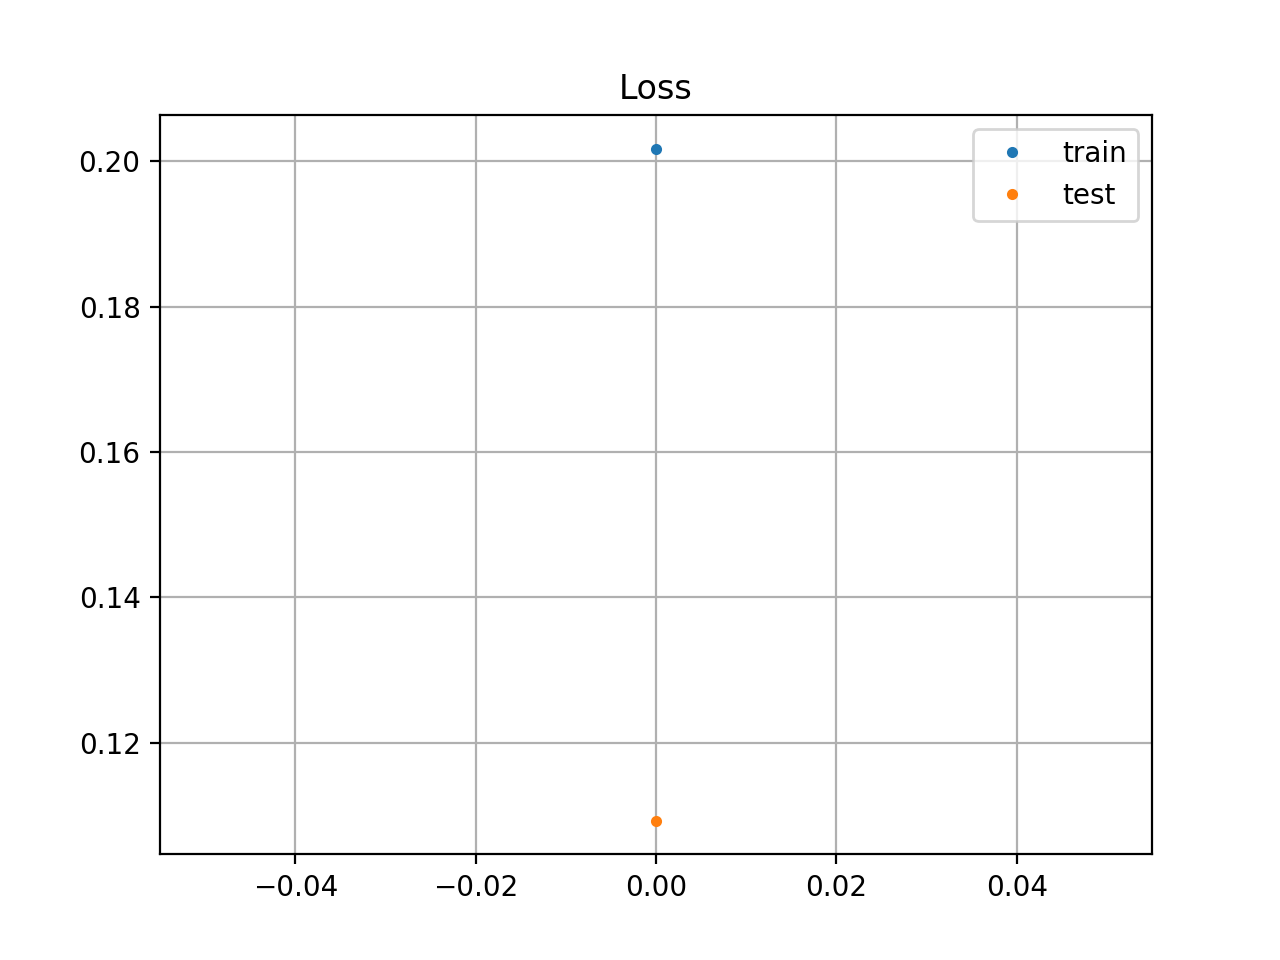

<IPython.core.display.Javascript object>


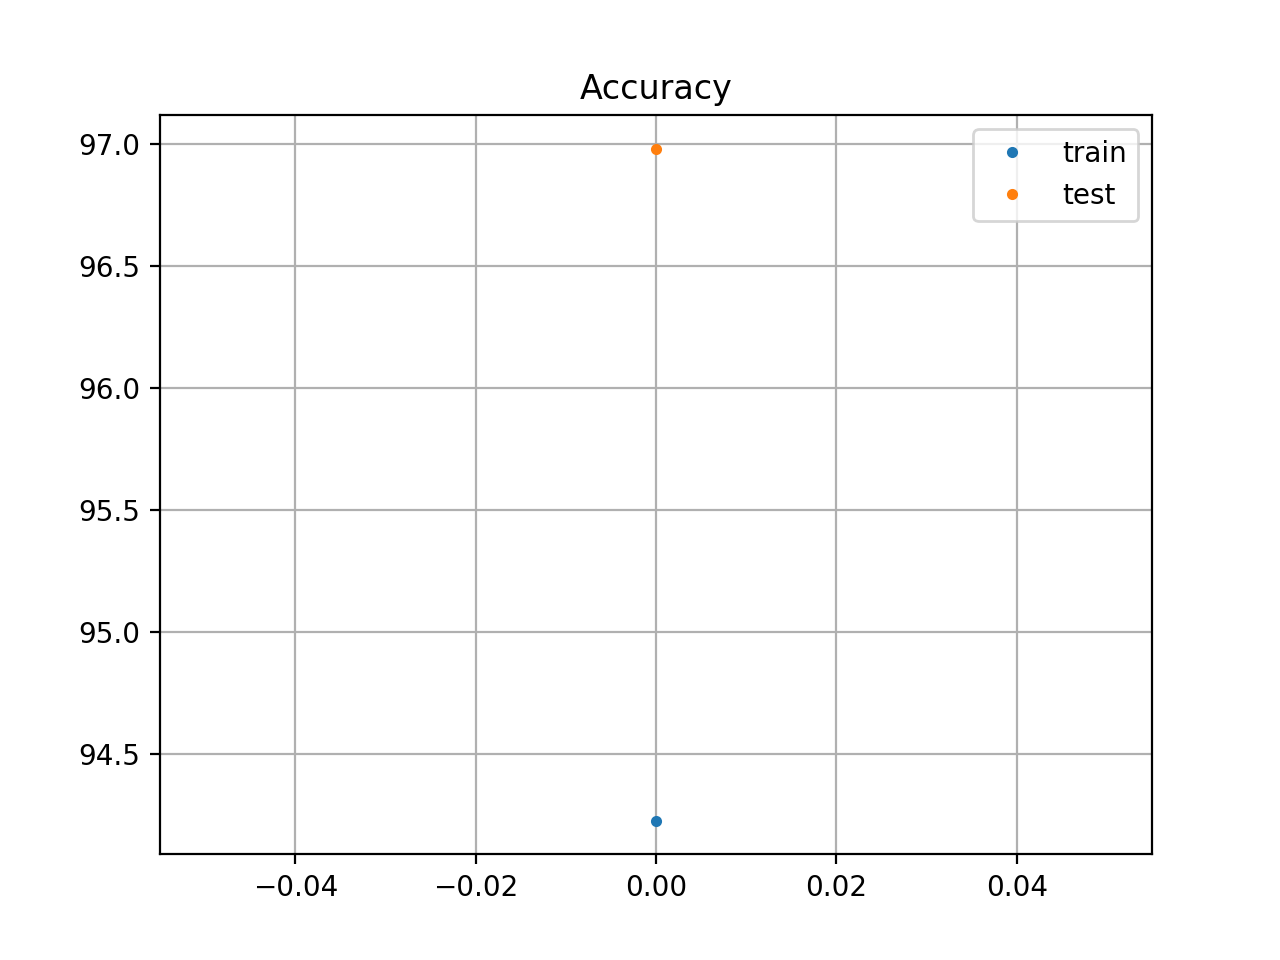

In [16]:
# acc and loss hist
plt.plot(train_histories['train_loss_hist'], marker='.', linestyle=' ', label='train')
plt.plot(train_histories['test_loss_hist'], marker='.', linestyle=' ', label='test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(train_histories['train_acc_hist'], marker='.', linestyle=' ', label='train')
plt.plot(train_histories['test_acc_hist'], marker='.', linestyle=' ', label='test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

In [18]:
# 4 - histogram over train/val data

DescribeResult(nobs=50000, minmax=(0.10000000149011612, 0.9999717473983765), mean=0.969120376842171, variance=0.008874601924154023, skewness=-4.653716989829409, kurtosis=24.97337437504728)
percentage of confident (>0.5) predictions: 0.99038


<IPython.core.display.Javascript object>


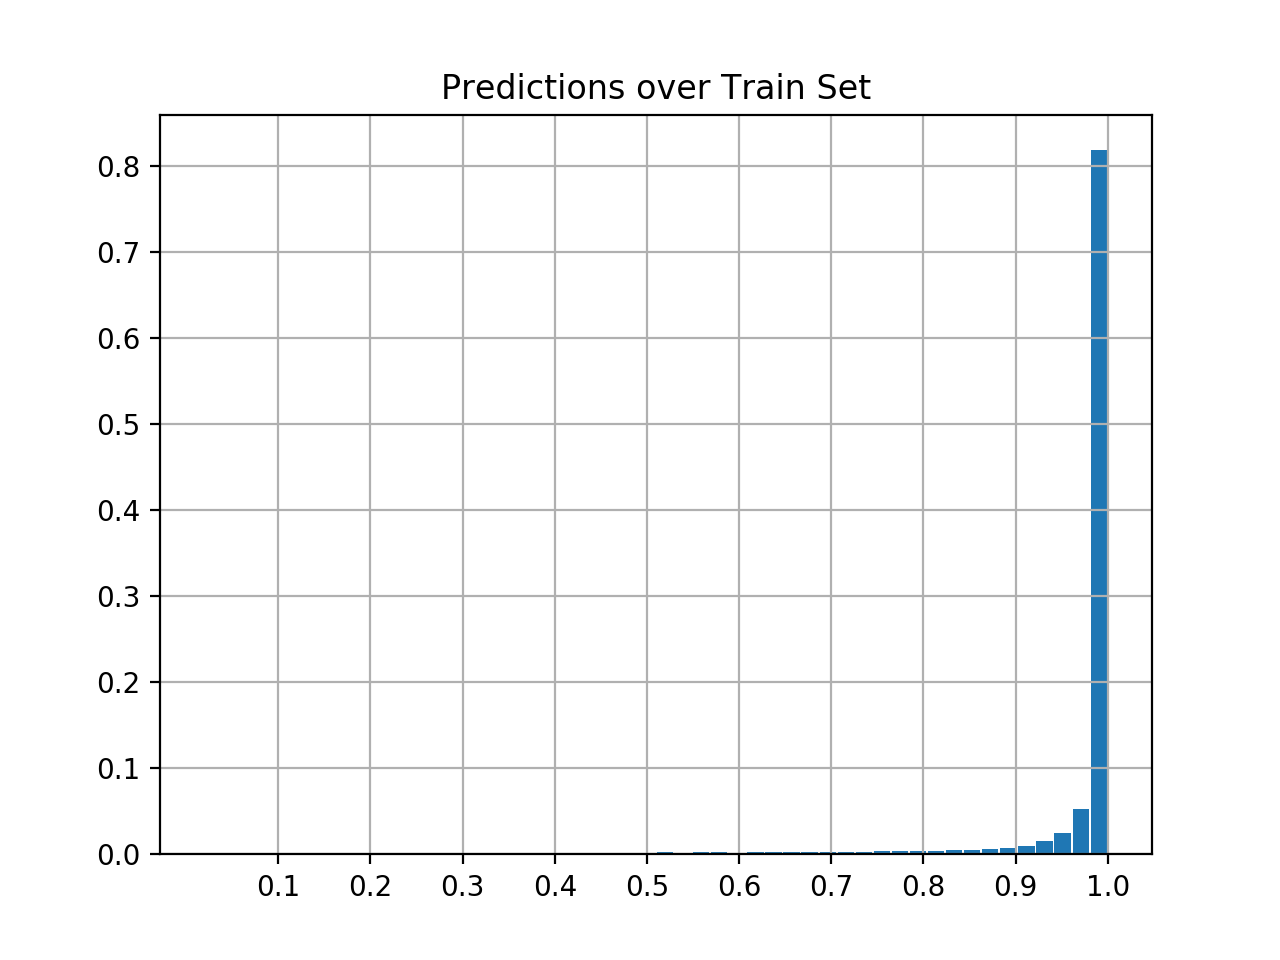

In [17]:
# histogram over MNIST train data
preds_maxes = np.array([])
with torch.no_grad():
    for x_mnist,_ in mnist_train_loader:
        preds = model(x_mnist.to(device))
        # apply softmax for probs
        preds_mnist_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds.cpu().detach().numpy()])
        # only save max
        preds_maxes = np.concatenate((preds_maxes, np.max(preds_mnist_softmax, axis=1)))
        # clean up GPU
#         torch.cuda.empty_cache()
    
#     try:
#         preds_mnist_train = np.concatenate((preds_mnist_train, preds.cpu().detach().numpy()))
#     except:
#         preds_mnist_train = preds.cpu().detach().numpy()
# # apply softmax for probs
# preds_mnist_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds_mnist_train])
# quick description of the maxes
# preds_maxes = np.max(preds_mnist_softmax, axis=1)

print(stats.describe(preds_maxes))
# % of maxes above 0.5
print("percentage of confident (>0.5) predictions:",float(len([x for x in preds_maxes if x>=0.5])/float(len(preds_maxes))))

# histogram
weights = np.ones_like(preds_maxes)/len(preds_maxes)
plt.hist(preds_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.title("Predictions over Train Set")
plt.show()

DescribeResult(nobs=10000, minmax=(0.10000000149011612, 0.9999681115150452), mean=0.9698755857177078, variance=0.008880153006241264, skewness=-4.629179054284409, kurtosis=24.11186145557603)
percentage of confident (>0.5) predictions: 0.9897


<IPython.core.display.Javascript object>


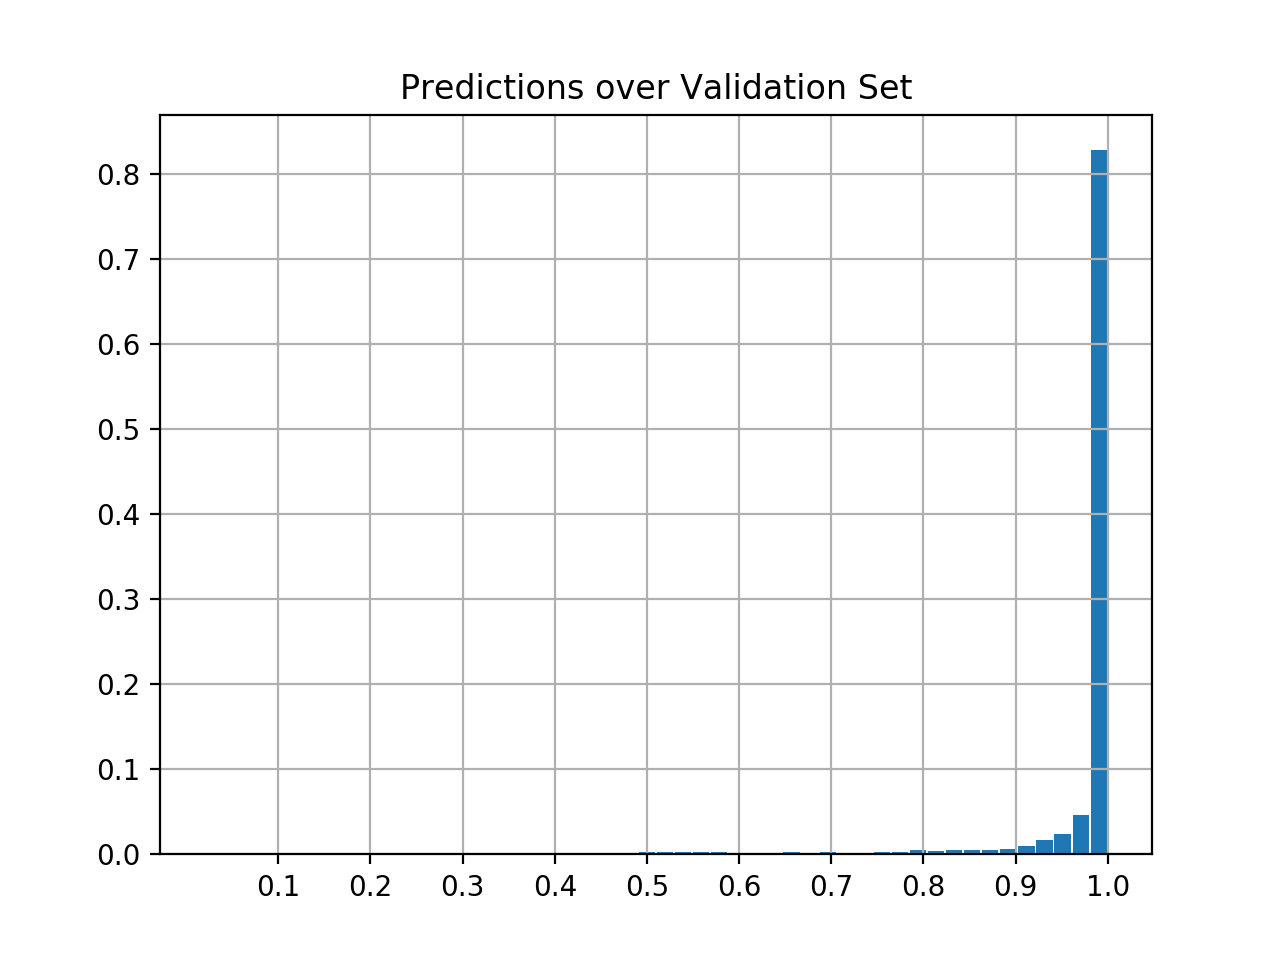

In [18]:
# histogram over MNIST val data
preds_maxes = np.array([])
with torch.no_grad():
    for x_mnist,_ in mnist_val_loader:
        preds = model(x_mnist.to(device))
        # apply softmax for probs
        preds_mnist_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds.cpu().detach().numpy()])
        # only save max
        preds_maxes = np.concatenate((preds_maxes, np.max(preds_mnist_softmax, axis=1)))

# quick description of the maxes
print(stats.describe(preds_maxes))
# % of maxes above 0.5
print("percentage of confident (>0.5) predictions:",float(len([x for x in preds_maxes if x>=0.5])/float(len(preds_maxes))))

# histogram
weights = np.ones_like(preds_maxes)/len(preds_maxes)
plt.hist(preds_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.title("Predictions over Validation Set")
plt.show()

In [19]:
# 5 - predictions over noise

In [20]:
white_noise_dataloader = fgnh.mnist_random_dataloader(num_samples=50000, batch_size=10000)
shuffled_noise_dataloader = fgnh.mnist_random_shuffled_dataloader(num_samples=50000, batch_size=10000)

<IPython.core.display.Javascript object>


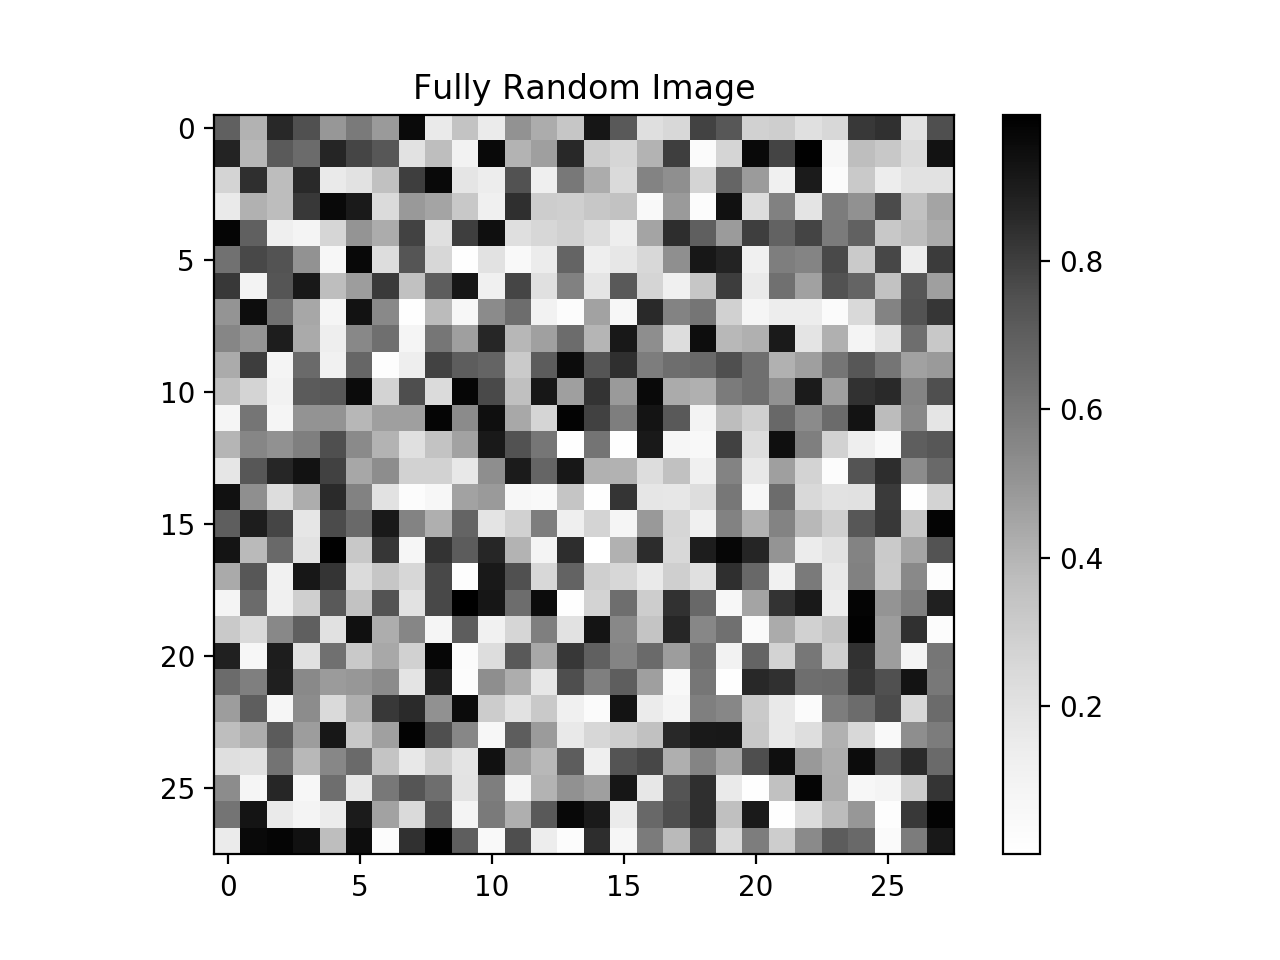

<IPython.core.display.Javascript object>


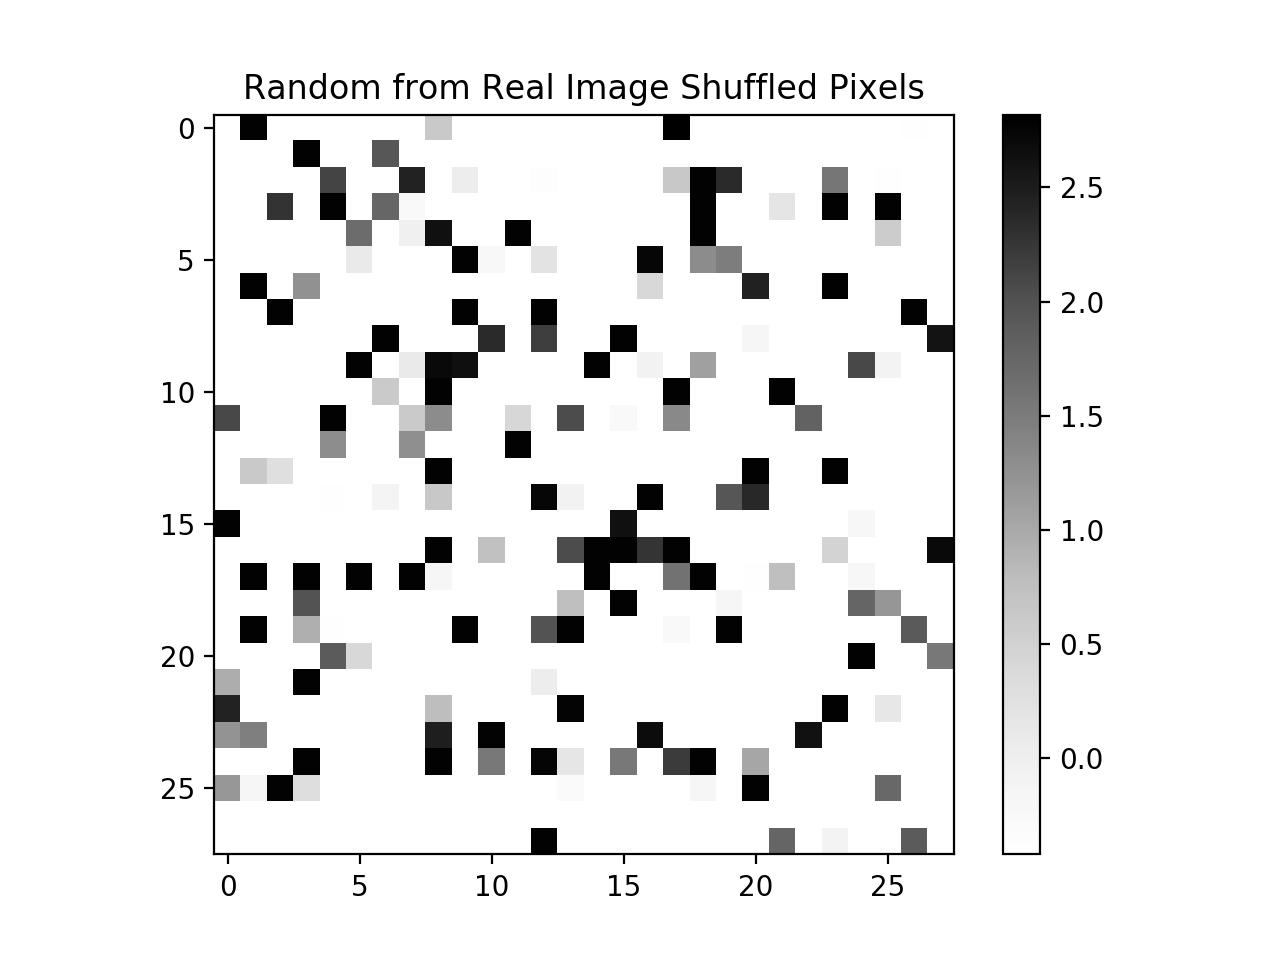

In [21]:
# show examples
x = white_noise_dataloader.dataset.tensors[0][0]
plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.title('Fully Random Image')
plt.colorbar()
plt.show()

x = shuffled_noise_dataloader.dataset.tensors[0][0]
plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.title('Random from Real Image Shuffled Pixels')
plt.colorbar()
plt.show()

DescribeResult(nobs=50000, minmax=(0.10000000149011612, 0.10000000149011612), mean=0.10000000149011612, variance=0.0, skewness=0.0, kurtosis=-3.0)
percentage of confident (>0.5) predictions: 0.0


<IPython.core.display.Javascript object>


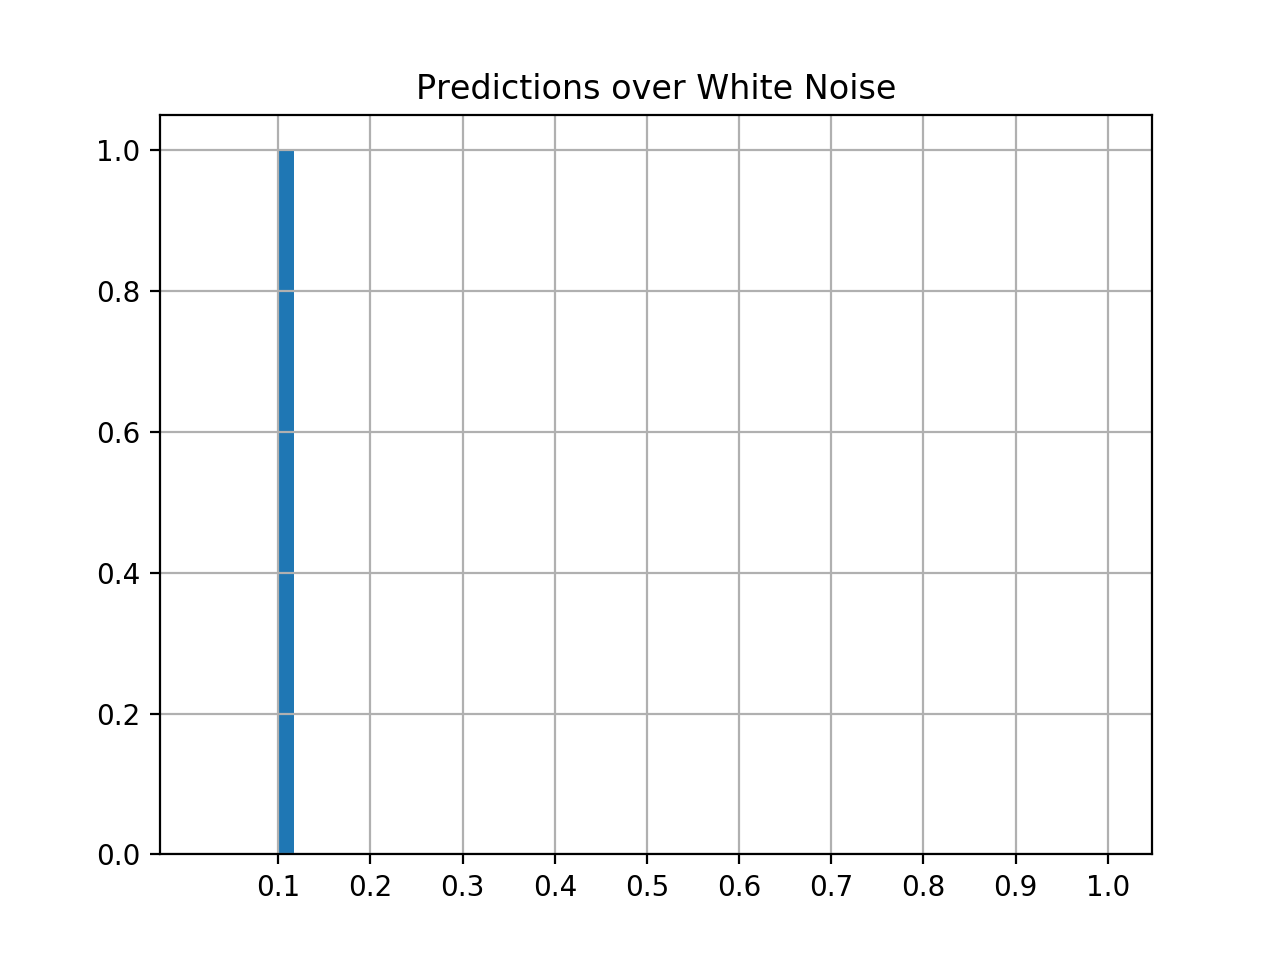

In [24]:
# histogram over white noise data
preds_maxes = np.array([])
with torch.no_grad():
    for x_white_noise in white_noise_dataloader:
        preds = model(x_white_noise[0].to(device))
        # apply softmax for probs
        preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds.cpu().detach().numpy()])
        # only save max
        preds_maxes = np.concatenate((preds_maxes, np.max(preds_softmax, axis=1)))


# quick description of the maxes
print(stats.describe(preds_maxes))
# % of maxes above 0.5
print("percentage of confident (>0.5) predictions:",float(len([x for x in preds_maxes if x>=0.5])/float(len(preds_maxes))))

# histogram
weights = np.ones_like(preds_maxes)/len(preds_maxes)
plt.hist(preds_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.title("Predictions over White Noise")
plt.show()

DescribeResult(nobs=50000, minmax=(0.10000000149011612, 0.6449894905090332), mean=0.13631122001871468, variance=0.016007990436235343, skewness=3.1974255076679774, kurtosis=8.223786104417846)
percentage of confident (>0.5) predictions: 0.0761


<IPython.core.display.Javascript object>


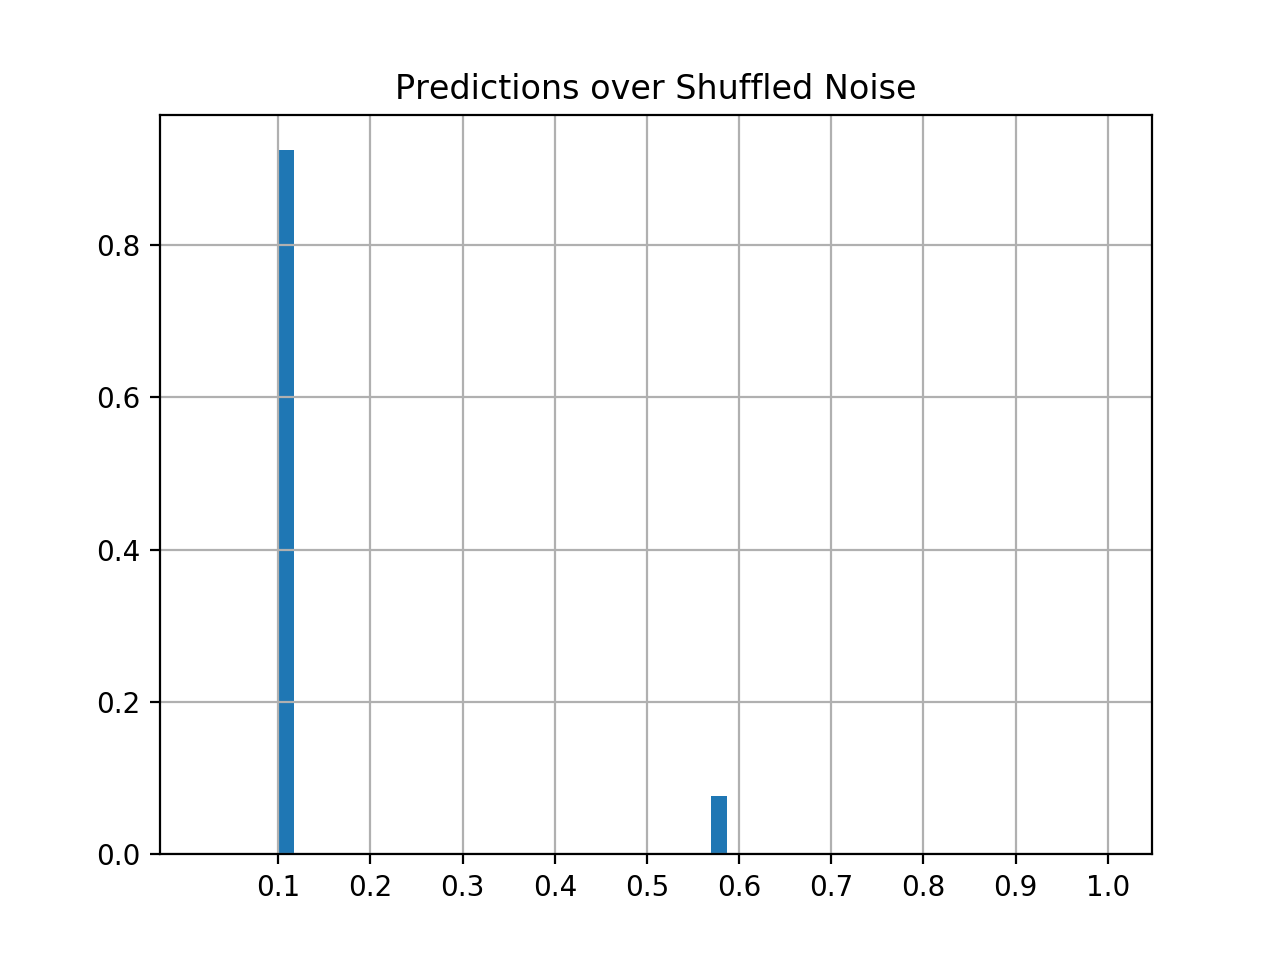

In [25]:
# histogram over shuffled noise data
preds_maxes = np.array([])
with torch.no_grad():
    for x_white_noise in shuffled_noise_dataloader:
        preds = model(x_white_noise[0].to(device))
        # apply softmax for probs
        preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds.cpu().detach().numpy()])
        # only save max
        preds_maxes = np.concatenate((preds_maxes, np.max(preds_softmax, axis=1)))


# quick description of the maxes
print(stats.describe(preds_maxes))
# % of maxes above 0.5
print("percentage of confident (>0.5) predictions:",float(len([x for x in preds_maxes if x>=0.5])/float(len(preds_maxes))))

# histogram
weights = np.ones_like(preds_maxes)/len(preds_maxes)
plt.hist(preds_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.title("Predictions over Shuffled Noise")
plt.show()